In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from sklearn.utils.extmath import randomized_svd as fast_svd
from sklearn.decomposition import PCA
from hyperspy import signals

In [51]:
# path to raw data, denoised data, and ground truth
# no data exceeds 2GB thus they are all saved in .mat or .py
path ='/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/'
raw_data = sio.loadmat(path + 'Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'Simulation_tensor_SiDisl_slc5_1000FPS.mat')
denoised_data = denoised_data['est_HOOI']

In [52]:
# reshape the 3D tensor into 2D matrix
# raw_data = raw_data[0:-1:5,0:-1:5,:]
raw_data.shape
raw_data_2D = np.reshape(raw_data,(raw_data.shape[0]*raw_data.shape[1],raw_data.shape[2]))

## Fullsize Si simulation data, r-space as navigation dim and k-space as signal dim

In [56]:
im = signals.Signal2D(np.transpose(raw_data_2D.astype('float')))
im = im.transpose(signal_axes = 1)
im = im.T
im

<Signal1D, title: , dimensions: (12996|16384)>

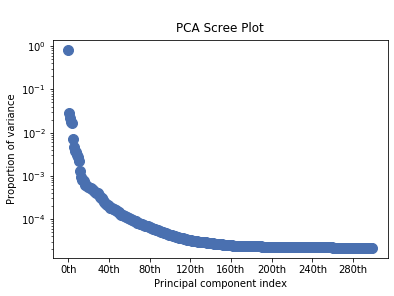

In [57]:
im.decomposition()
im.plot_explained_variance_ratio(n=300,linewidth=1)

In [67]:
# denoise with 190 components
im_denoise = im.get_decomposition_model(60)

In [68]:
denoised_data = np.asarray(im_denoise)
print(denoised_data.shape)
denoised_data = denoised_data.reshape([114,114,16384])
print(denoised_data.shape)
# np.save(path + 'Simulation_PCA_SiDisl_slc5_1000FPS.npy', denoised_data)

(12996, 16384)
(114, 114, 16384)


In [69]:
print(averagePSNR(denoised_data,truth_data,0))

34.072239946294395


In [112]:
denoised_data.shape

(128, 128, 12996)

## Compare hyperspy PCA results with tensor SVD results

In [126]:
denoise_file = np.asarray(im_denoise)
denoise_file = denoise_file.reshape([16384,114,114])

In [127]:
denoise_file = np.transpose(denoise_file,(1,2,0))

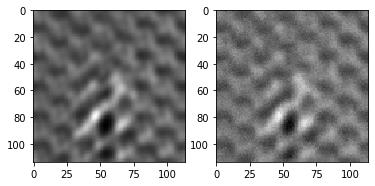

In [130]:
plt.subplot(121)
plt.imshow(truth_file[:,:,10000])
plt.subplot(122)
plt.imshow(denoise_file[:,:,10000])

In [128]:
print(truth_file.shape)
print(denoise_file.shape)

(114, 114, 16384)
(114, 114, 16384)


In [71]:
FPS_list = [1000,2000,4000,6000,8000,10000,20000,40000]
FPS_list = [1000]
PSNR_list = np.zeros((3,len(FPS_list)))
path = '/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/'
for i in range(len(FPS_list)):
    FPS = FPS_list[i]
    truth_file = path + 'Simulation_truth_SiDisl_slc5_'+str(FPS)+'FPS.npy'
    noisy_file = path + 'Simulation_noisy_SiDisl_slc5_'+str(FPS)+'FPS.mat'
    denoise_file = path + 'Simulation_tensor_SiDisl_slc5_'+str(FPS)+'FPS.mat'
    truth_file = np.load(truth_file)
    noisy_file = sio.loadmat(noisy_file)
    noisy_file = noisy_file['datacube']

    denoise_file = sio.loadmat(denoise_file)
    denoise_file = denoise_file['est_HOOI']
    
    PSNR_list[0,i] = averagePSNR(denoise_file,truth_file,0)
    PSNR_list[1,i] = averagePSNR(noisy_file,truth_file,0)
    print(FPS)
#     print(PSNR_list[:,i])
    
    # run Hyperspy PCA and calculate 
    raw_data_2D = np.reshape(noisy_file,(114*114,16384))
    im = signals.Signal2D(np.transpose(raw_data_2D.astype('float')))
    im = im.transpose(signal_axes = 1)
    im.decomposition()
    im_denoise = im.get_decomposition_model(190)
    denoise_file = np.asarray(im_denoise)
    denoise_file = denoise_file.reshape([16384,114,114])
    denoise_file = np.transpose(denoise_file,(1,2,0))
    PSNR_list[2,i] = averagePSNR(denoise_file,truth_file,0)
    print(PSNR_list[:,i])

1000
[38.79368233 22.50108175 34.93763118]


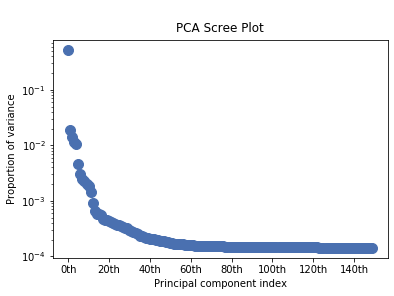

In [67]:
im.plot_explained_variance_ratio(n=150,linewidth=1)

28.148617582644306


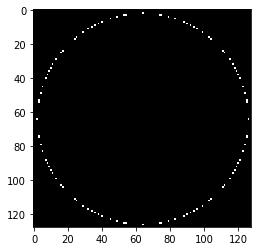

In [68]:
im_denoise = im.get_decomposition_model(80)
denoise_file = np.asarray(im_denoise)
denoise_file = denoise_file.reshape([16384,114,114])
denoise_file = np.transpose(denoise_file,(1,2,0))
print(averagePSNR(denoise_file,truth_file,0))

# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=62) & \
~create_circular_mask(128, 128, center=(64,64), radius=61.7)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + noisy_file[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoise_file[:,:,i*128+j]
            ADF_truth = ADF_truth + truth_file[:,:,i*128+j]

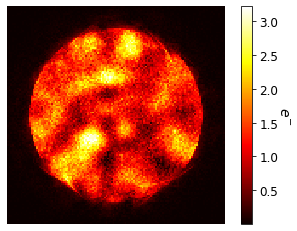

In [69]:
denoise_file.shape
rx = 50
ry = 60
clim_low = np.amin(truth_file[rx,ry,:])
clim_high = np.amax(truth_file[rx,ry,:])
plt.imshow(denoise_file[rx,ry,:].reshape(128,128),cmap='hot',clim=[clim_low,clim_high])
plt.axis('off')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)

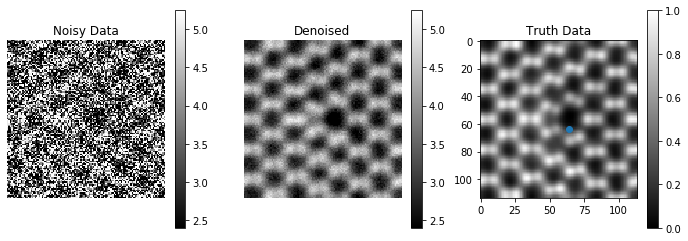

In [70]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

plt.subplot(132)
plt.imshow(ADF_denoised,clim=[clim_low,clim_high])
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high])
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.imshow(ADF_truth,clim=[clim_low,clim_high])
plt.title('Truth Data')
plt.scatter(64,64)
# plt.axis('off')
plt.colorbar()

## Matrix SVD on experimental STO data

In [14]:
path ='/srv/home/chenyu/TensorDenoise/Experiment/'
raw_data = sio.loadmat(path + 'Experiment_noisy_STO_010619_S3.mat')
raw_data = raw_data['datacube']
print(raw_data.shape)

raw_data_2D = np.reshape(raw_data,(149*149,16384))
im = signals.Signal2D(np.transpose(raw_data_2D.astype('float')))
im = im.transpose(signal_axes = 1)
im.decomposition()

(149, 149, 16384)


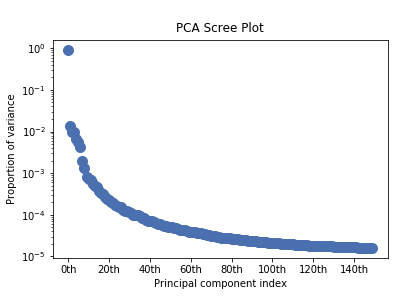

In [15]:
im.plot_explained_variance_ratio(n=150,linewidth=1)

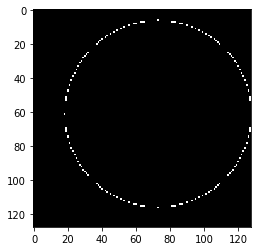

In [16]:
im_denoise = im.get_decomposition_model(80)
denoise_file = np.asarray(im_denoise)
denoise_file = denoise_file.reshape([16384,149,149])
denoise_file = np.transpose(denoise_file,(1,2,0))

# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(73,61), radius=55) & \
~create_circular_mask(128, 128, center=(73,61), radius=54.5)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoise_file[:,:,i*128+j]

In [20]:
np.save('/srv/home/chenyu/TensorDenoise/Experiment/Experiment_PCA_STO_010619_S3_80.npy',denoise_file)

Text(0.5, 1.0, 'Denoised')

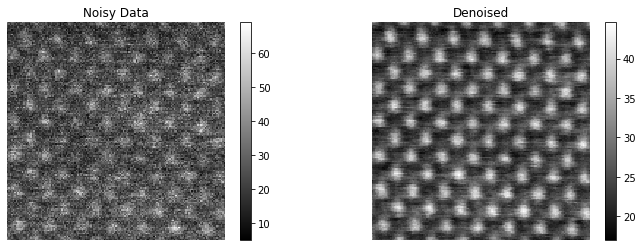

In [17]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.imshow(ADF_noisy)
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(122)
plt.imshow(ADF_denoised)
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

Text(0.5, 1.0, 'Denoised')

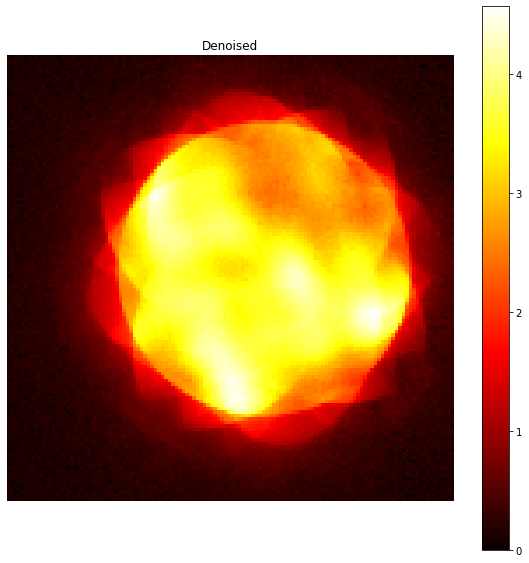

In [19]:
temp = denoise_file[50,50,:].reshape(128,128)
temp[temp<0] = 0
fig = plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(temp),cmap='hot')
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

## Matrix SVD on experimental LiZnSb data

In [21]:
path ='/srv/home/chenyu/TensorDenoise/Experiment/'
raw_data = sio.loadmat(path + 'Experiment_noisy_LiZnSb.mat')
raw_data = raw_data['datacube']
print(raw_data.shape)

raw_data_2D = np.reshape(raw_data,(150*150,16384))
im = signals.Signal2D(np.transpose(raw_data_2D.astype('float')))
im = im.transpose(signal_axes = 1)
im.decomposition()

(150, 150, 16384)


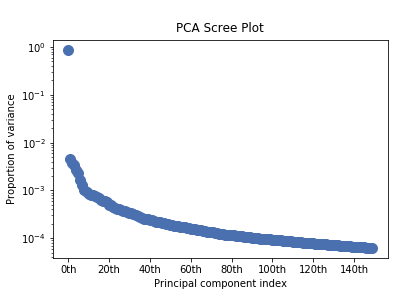

In [22]:
im.plot_explained_variance_ratio(n=150,linewidth=1)

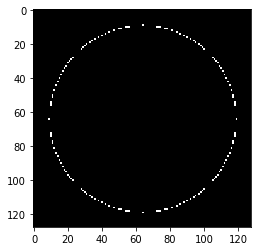

In [23]:
im_denoise = im.get_decomposition_model(80)
denoise_file = np.asarray(im_denoise)
denoise_file = denoise_file.reshape([16384,150,150])
denoise_file = np.transpose(denoise_file,(1,2,0))

# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=55) & \
~create_circular_mask(128, 128, center=(64,64), radius=54.5)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoise_file[:,:,i*128+j]

In [24]:
np.save('/srv/home/chenyu/TensorDenoise/Experiment/Experiment_PCA_LiZnSb_80.npy',denoise_file)

Text(0.5, 1.0, 'Denoised')

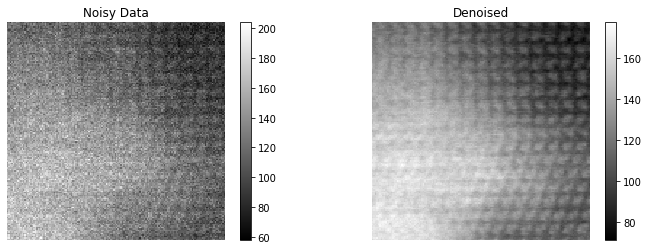

In [25]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.imshow(ADF_noisy)
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(122)
plt.imshow(ADF_denoised)
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

Text(0.5, 1.0, 'Denoised')

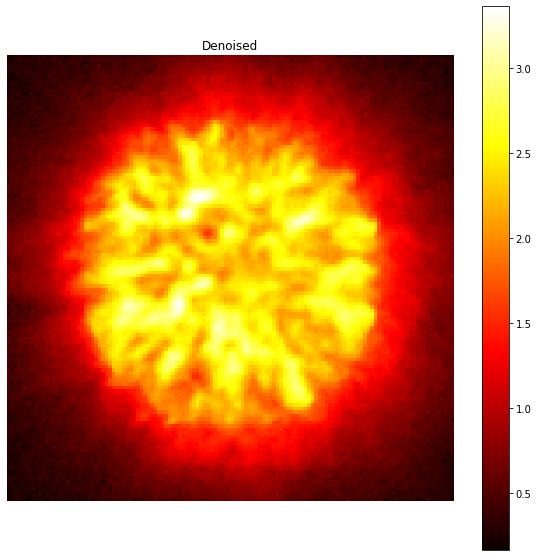

In [26]:
temp = denoise_file[50,50,:].reshape(128,128)
temp[temp<0] = 0
fig = plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(temp),cmap='hot')
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

## Hyperspy PCA, reduced k-space pixels

In [ ]:
# path to raw data, denoised data, and ground truth
# no data exceeds 2GB thus they are all saved in .mat or .py
path ='/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/'
raw_data = sio.loadmat(path + 'Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'Simulation_tensor_SiDisl_slc5_1000FPS.mat')
denoised_data = denoised_data['est_HOOI']

In [8]:
# transpose_option = 1 for tensor denoised data, where first dimension is for rec space and need to be transposed to match simulation
# transpose_option = 0 for noisy data, third dimension is for rec space and no need to transpose
def averagePSNR(denoised_data,truth_data,transpose_option):
    side = np.sqrt(truth_data.shape[2])
    side = int(side)
    psnr_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))
    for irow in range(truth_data.shape[0]):
        for icol in range(truth_data.shape[1]):
            truth = truth_data[irow,icol,:].reshape(side,side)
            if transpose_option == 1:
                denoise = np.transpose(denoised_data[:,irow,icol].reshape(side,side))
            else:
                denoise = denoised_data[irow,icol,:].reshape(side,side)
            psnr_map[irow,icol] = psnr(truth,denoise)
    return np.mean(psnr_map)

In [9]:
def psnr(truth, denoise):
    mse = np.mean( (truth - denoise) ** 2 )
    PIXEL_MAX = np.amax(truth)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [10]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask